In [1]:
#主要库
import torch
import sys
#用于构建神经网络的模块
import torch.nn as nn
#包含了所有的优化算法优化器
import torch.optim as optim
#用于计算机视觉任务中的数据处理
import torchvision
import torchvision.transforms as transforms
#画图
import matplotlib.pyplot as plt
import random
import numpy as np

In [6]:
#定义了ResNet模型的基本块，包含两个卷积层、批归一化层和残差连接。
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        #确保基本块类具有nn.Module的所有功能，并且可以在基本块中添加自定义的属性和方法。
        super(BasicBlock, self).__init__()
        # self.conv1：第一个卷积层，使用3x3的卷积核，步幅为stride，填充为1，不使用偏置（bias=False）。
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # self.bn1：第一个批归一化层，对out_channels进行归一化操作。
        self.bn1 = nn.BatchNorm2d(out_channels)
        # self.relu：ReLU激活函数。
        self.relu = nn.ReLU(inplace=True)
        # self.conv2：第二个卷积层，使用3x3的卷积核，步幅为1，填充为1，不使用偏置。
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # self.bn2：第二个批归一化层，对out_channels进行归一化操作。
        self.bn2 = nn.BatchNorm2d(out_channels)
        # self.shortcut：残差连接的捷径路径。如果步幅不为1或输入通道数不等于self.expansion * out_channels，
        # 则创建一个包含1x1卷积层和批归一化层的Sequential模块，用于匹配维度。
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        # x首先被保存为identity
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # 将捷径路径的结果与特征提取后的结果相加，然后再次通过ReLU激活函数。
        out += self.shortcut(identity)
        out = self.relu(out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        # 确保基本块类具有nn.Module的所有功能，并且可以在基本块中添加自定义的属性和方法。
        super(ResNet, self).__init__()
        self.in_channels = 64
        #第一个卷积层，输入通道数为3（RGB图像），输出通道数为64，使用3x3的卷积核，步幅为1，填充为1，不使用偏置。
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # 第一个批归一化层，对64个输出通道进行归一化操作。
        self.bn1 = nn.BatchNorm2d(64)
        # 四个残差层，分别调用self.make_layer()方法创建。
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        # 自适应平均池化层，将特征图池化为大小为1x1的特征图。
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # 全连接层，将池化后的特征图展平，并输出到num_classes个类别。
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        # 根据基本块的数量num_blocks生成步幅列表strides，其中第一个元素为给定的步幅值，后续元素都为1。
        strides = [stride] + [1] * (num_blocks - 1)
        # 通过循环遍历步幅列表，在每个步幅下创建一个基本块，并将其添加到layers列表中。
        layers = []
        for stride in strides:
            # 在创建基本块时，更新输入通道数self.in_channels为当前输出通道数乘以基本块的扩展系数block.expansion
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        # 使用nn.Sequential()将所有基本块组合成一个Sequential模块，并返回
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # 通过自适应平均池化层self.avg_pool将特征图池化为大小为1x1的特征图
        out = self.avg_pool(out)
        # 将特征图展平为一维向量
        out = torch.flatten(out, 1)
        # 将展平后的特征向量传递给全连接层self.fc进行分类，并返回输出结果
        out = self.fc(out)
        return out

In [8]:
# 定义测试函数
def test_resnet(model, test_loader, criterion):
    # 将模型设置为评估模式，即调用model.eval()。
    model.eval()
    # 初始化变量correct、total和test_loss，分别用于记录正确预测的样本数、总样本数和测试损失。
    correct = 0
    total = 0
    test_loss = 0.0
    # 使用torch.no_grad()上下文管理器，关闭梯度计算，以减少内存消耗和加速计算。
    with torch.no_grad():
        for inputs, labels in test_loader:
            #将数据和标签移动到gpu
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # 使用损失函数计算预测结果与真实标签之间的损失(loss)，并将其累加到test_loss中。
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # outputs.max(1)会返回每个样本在模型输出中的最大值和对应的索引，即预测结果。
            # 通过加下划线 _，忽略了最大值，只保留了索引。
            _, predicted = outputs.max(1)
            # 前批次中样本的数量。
            total += labels.size(0)
            # 最后，predicted.eq(labels).sum().item()会计算预测结果与真实标签相等的数量，并将其加到correct变量中，表示正确预测的样本数量。
            correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    average_loss = test_loss / len(test_loader)
    print(f"Test Accuracy: {accuracy:.2f}%, Average Loss: {average_loss:.4f}")

In [9]:
# 如果CUDA可用，则选择GPU设备（"cuda"），否则选择CPU设备（"cpu"）。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#训练的轮数和每个批次样本的数量
num_epochs = 50
batch_size = 128

# 载入CIFAR-10数据集，多个转换操作组合
transform = transforms.Compose([
    # 随机水平翻转
    transforms.RandomHorizontalFlip(),
    # 随机裁剪
    transforms.RandomCrop(32, padding=4),
    # 将图像转换为张量、以及归一化处理
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 使用torchvision库中的datasets.CIFAR10函数来加载CIFAR-10数据集。train=True表示加载训练集，train=False表示加载测试集。
# transform=transform表示应用之前定义的数据预处理转换操作。
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 划分训练集和验证集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
#训练集占总体的80%，验证集占20%。
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

#batch_size参数指定每个批次的样本数量，shuffle参数表示是否在每个轮次之前打乱数据顺序，num_workers参数表示用于数据加载的线程数。
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 创建ResNet模型实例
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

# 多类别分类任务的交叉熵损失函数。
criterion = nn.CrossEntropyLoss()
# 随机梯度下降（SGD）算法的优化器，用于更新模型的参数。
optimizer = optim.Adam(model.parameters(), lr=0.01)

Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50], Train Loss: 1.8673, Validation Loss: 1.6604, Test Loss: 1.6580, Train Accuracy: 31.09%, Validation Accuracy: 40.38%
Epoch [2/50], Train Loss: 1.3937, Validation Loss: 1.2657, Test Loss: 1.2445, Train Accuracy: 48.86%, Validation Accuracy: 54.81%
Epoch [3/50], Train Loss: 1.1008, Validation Loss: 1.0476, Test Loss: 1.0428, Train Accuracy: 60.67%, Validation Accuracy: 63.10%
Epoch [4/50], Train Loss: 0.9050, Validation Loss: 1.0462, Test Loss: 1.0606, Train Accuracy: 67.98%, Validation Accuracy: 63.65%
Epoch [5/50], Train Loss: 0.7743, Validation Loss: 0.9275, Test Loss: 0.9450, Train Accuracy: 72.54%, Validation Accuracy: 69.59%
Epoch [6/50], Train Loss: 0.6570, Validation Loss: 0.7977, Test Loss: 0.8128, Train Accuracy: 77.02%, Validation Accuracy: 72.86%
Epoch [7/50], Train Loss: 0.5705, Validation Loss: 0.6275, Test Loss: 0.6237, Train Accuracy: 80.02%, Validation Accuracy: 78.49%
Epoch [8/50], Train Loss: 0.5127, Validation Loss: 0.5732, Test Loss: 0.5859, Train Accura

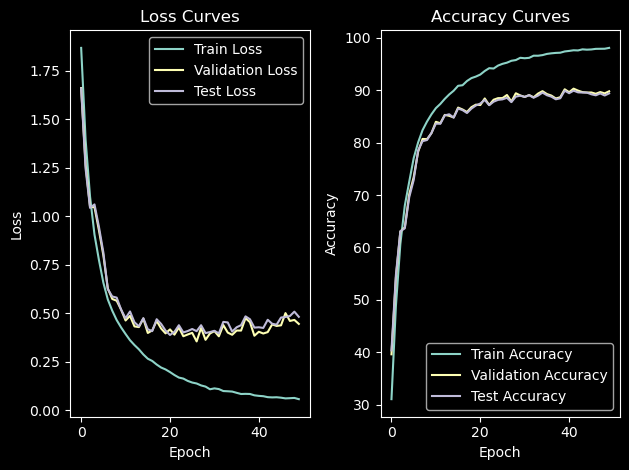

Test Accuracy: 89.73%, Average Loss: 0.4248


In [40]:
# 训练ResNet模型
best_accuracy = 0.0
# 用于绘模型损失函数的变化曲线图
train_losses = []
valid_losses = []
test_losses = []
train_accuracies = []
valid_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100.0 * correct / total
    train_accuracies.append(train_accuracy)

    # 在每个epoch结束后，通过切换模型为评估模式(model.eval())，
    # 计算验证集和测试集上的损失和准确度。
    model.eval()
    valid_loss = 0.0
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        valid_loss /= len(valid_loader)
        accuracy = 100.0 * correct / total
        valid_losses.append(valid_loss)
        valid_accuracies.append(accuracy)

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        test_loss /= len(test_loader)
        accuracy = 100.0 * correct / total
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

    # 保存在验证集上精度最好的模型
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'resnet_model.pth')

# 绘制损失曲线图
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# 绘制准确度曲线图
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

# 加载保存的模型并在测试集上进行评估
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
model.load_state_dict(torch.load('resnet_model.pth'))
test_resnet(model, test_loader, criterion)

In [41]:
#转换模型格式为onnx用于架构图可视化
model = ResNet(BasicBlock, [2, 2, 2, 2]) # 构建模型
model.load_state_dict(torch.load('resnet_model.pth')) # 加载状态字典
model.eval() # 设置为评估模式
#32x32的RGB图像,所以输入通道是3
example_input = torch.randn(1, 3, 32, 32)
torch.onnx.export(model, 
                  example_input, 
                  "resnet.onnx", 
                  export_params=True,
                  opset_version=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


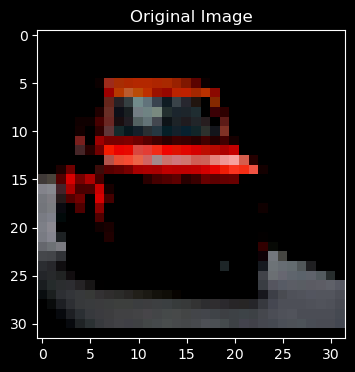

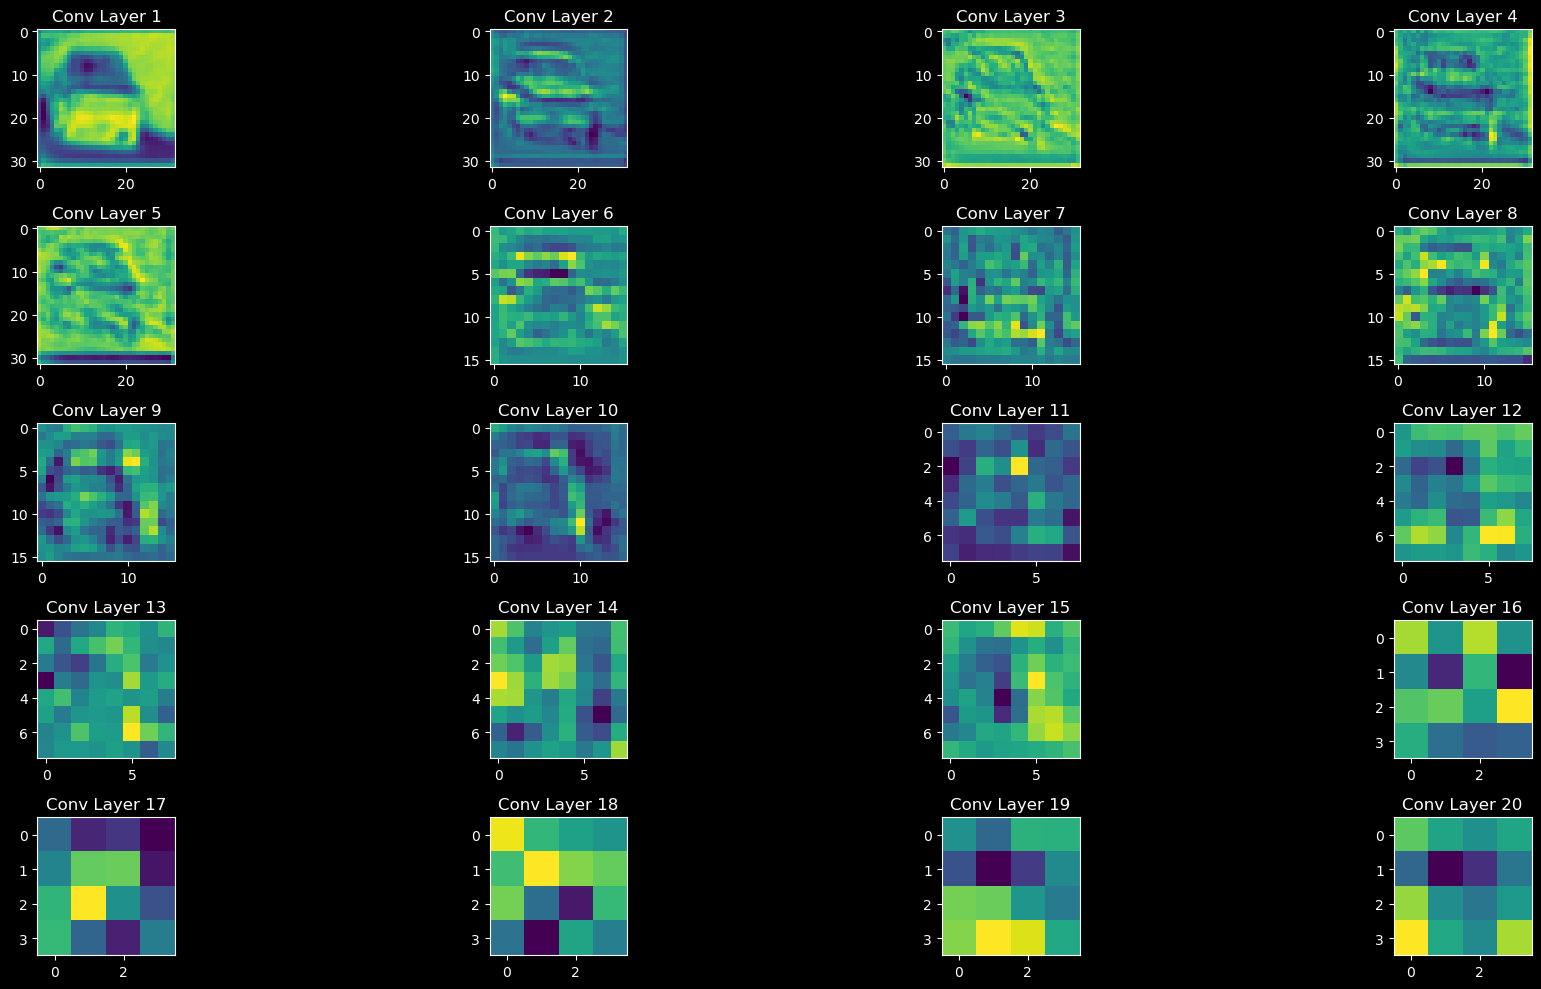

In [11]:

# 定义模型
model = ResNet(BasicBlock, [2, 2, 2, 2])
model.load_state_dict(torch.load('resnet_model.pth'))
model.eval()

# 定义hook函数
features = []
def hook(module, input, output):
    features.append(output.detach())

# 注册hook
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        module.register_forward_hook(hook)

# 取训练数据的一个随机批次
inputs, labels = next(iter(train_loader)) 


img = inputs[0].numpy().transpose(1, 2, 0)
print(labels[0].item())
plt.figure(figsize=(4, 4))
plt.imshow(img) 
plt.title('Original Image')
plt.show()

# 模型前向计算
output = model(inputs)


# 可视化特征图
plt.figure(figsize=(20, 10))
for i, f in enumerate(features):
    plt.subplot(5, 4, i+1) 
    plt.imshow(f[0, 0].cpu())
    plt.title(f'Conv Layer {i+1}')
plt.tight_layout() 
plt.show()